In [1]:
#pip install influxdb


## Step 1: Data Fetching 


In [2]:
from influxdb import InfluxDBClient
import datetime
import pandas as pd
from termcolor import colored
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
# Set the needed parameters to connect to the database

settings = {
    'host': 'influxus.itu.dk',
    'port': 8086,
    'username': 'lsda',
    'password': 'icanonlyread'
    }

# Create an InfluxDB Client instance and select the orkney database

client = InfluxDBClient(host=settings['host'], port=settings['port'], username=settings['username'], password=settings['password'])
client.switch_database('orkney')

In [4]:
## Function to tranform the InfluxDB resulting set into a Dataframe
def set_to_dataframe(resulting_set):
    
    values = resulting_set.raw["series"][0]["values"]
    columns = resulting_set.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index

    return df

In [5]:
days = 90 # -> You can change this to get any other range of days

### YOU DON'T NEED TO CHANGE ANYTHING HERE ###
power_set = client.query(
    "SELECT * FROM Generation where time > now()-"+str(days)+"d"
    ) # Query written in InfluxQL. We are retrieving all generation data from 90 days back.

# Get the last 90 days of weather forecasts with the shortest lead time
wind_set  = client.query(
    "SELECT * FROM MetForecasts where time > now()-"+str(days)+"d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL. We are retrieving all weather forecast data from 90 days back and with 1 lead hour.

power_df = set_to_dataframe(power_set)
wind_df = set_to_dataframe(wind_set)

In [6]:
# data taken every minute
power_df.head()



,ANM,Non-ANM,Total
time,,,
2024-01-20 09:22:00+00:00,4.560870,14.031,18.591870
2024-01-20 09:23:00+00:00,4.551188,13.973,18.524188
2024-01-20 09:24:00+00:00,4.548716,13.859,18.407716
2024-01-20 09:25:00+00:00,4.493551,14.068,18.561551
2024-01-20 09:26:00+00:00,4.628533,13.651,18.279533


In [7]:
# data taken every 3 hours
wind_df.reset_index()

,time,Direction,Lead_hours,Source_time,Speed
0,2024-01-20 12:00:00+00:00,SSW,1,1705744800,8.94080
1,2024-01-20 15:00:00+00:00,S,1,1705755600,5.81152
2,2024-01-20 18:00:00+00:00,S,1,1705766400,11.17600
3,2024-01-20 21:00:00+00:00,S,1,1705777200,13.85824
4,2024-01-21 00:00:00+00:00,S,1,1705788000,16.09344
...,...,...,...,...,...
697,2024-04-18 21:00:00+00:00,NNW,1,1713463200,11.17600
698,2024-04-19 00:00:00+00:00,NNW,1,1713474000,12.07008
699,2024-04-19 03:00:00+00:00,NNW,1,1713484800,15.19936
700,2024-04-19 06:00:00+00:00,NNW,1,1713495600,13.85824


In [8]:
# Saving power_df to CSV
power_df.to_csv('power_data.csv', index=True)

# Saving wind_df to CSV
wind_df.to_csv('wind_data.csv', index=True)


In [9]:
power_df = power_df.reset_index()
print(power_df.head())


                       time       ANM  Non-ANM      Total
0 2024-01-20 09:22:00+00:00  4.560870   14.031  18.591870
1 2024-01-20 09:23:00+00:00  4.551188   13.973  18.524188
2 2024-01-20 09:24:00+00:00  4.548716   13.859  18.407716
3 2024-01-20 09:25:00+00:00  4.493551   14.068  18.561551
4 2024-01-20 09:26:00+00:00  4.628533   13.651  18.279533


In [10]:
# Encoding the direction of the wnd into degrees
direction_set = set(wind_df['Direction'])
#print(direction_set)

# Mapping dictionary from degrees from http://tamivox.org/dave/compass/
direction_mapping = {
    'N': 0,
    'NNE': 23,
    'NE': 45,
    'ENE': 67,
    'E': 90,
    'ESE': 112,
    'SE': 135,
    'SSE': 152,
    'S': 180,
    'SSW': 202,
    'SW': 225,
    'WSW': 247,
    'W': 270,
    'WNW': 293,
    'NW': 315,
    'NNW': 337
}

# Convert direction strings to numerical values
wind_df['Direction_Degrees'] = wind_df['Direction'].map(direction_mapping)
print(wind_df.head())


                          Direction Lead_hours  Source_time     Speed  \
time                                                                    
2024-01-20 12:00:00+00:00       SSW          1   1705744800   8.94080   
2024-01-20 15:00:00+00:00         S          1   1705755600   5.81152   
2024-01-20 18:00:00+00:00         S          1   1705766400  11.17600   
2024-01-20 21:00:00+00:00         S          1   1705777200  13.85824   
2024-01-21 00:00:00+00:00         S          1   1705788000  16.09344   

                           Direction_Degrees  
time                                          
2024-01-20 12:00:00+00:00                202  
2024-01-20 15:00:00+00:00                180  
2024-01-20 18:00:00+00:00                180  
2024-01-20 21:00:00+00:00                180  
2024-01-21 00:00:00+00:00                180  


In [11]:
wind_df = wind_df.reset_index()
print(wind_df.head())

                       time Direction Lead_hours  Source_time     Speed  \
0 2024-01-20 12:00:00+00:00       SSW          1   1705744800   8.94080   
1 2024-01-20 15:00:00+00:00         S          1   1705755600   5.81152   
2 2024-01-20 18:00:00+00:00         S          1   1705766400  11.17600   
3 2024-01-20 21:00:00+00:00         S          1   1705777200  13.85824   
4 2024-01-21 00:00:00+00:00         S          1   1705788000  16.09344   

   Direction_Degrees  
0                202  
1                180  
2                180  
3                180  
4                180  


In [12]:
merged = pd.merge(power_df, wind_df, on = "time", how='left')
row_200 = merged.iloc[199]
print(row_200)

time                 2024-01-20 12:41:00+00:00
ANM                                    5.22895
Non-ANM                                 14.012
Total                                 19.24095
Direction                                  NaN
Lead_hours                                 NaN
Source_time                                NaN
Speed                                      NaN
Direction_Degrees                          NaN
Name: 199, dtype: object


In [13]:

# Dropping the non needed columns 

columns_to_remove = ['time','ANM','Non-ANM','Direction', 'Lead_hours', 'Source_time']
merged.drop(columns=columns_to_remove, inplace=True)


In [14]:
merged.shape
merged.head

<bound method NDFrame.head of            Total  Speed  Direction_Degrees
0      18.591870    NaN                NaN
1      18.524188    NaN                NaN
2      18.407716    NaN                NaN
3      18.561551    NaN                NaN
4      18.279533    NaN                NaN
...          ...    ...                ...
81812  26.054348    NaN                NaN
81813  26.484115    NaN                NaN
81814  26.686420    NaN                NaN
81815  27.236970    NaN                NaN
81816  26.835087    NaN                NaN

[81817 rows x 3 columns]>

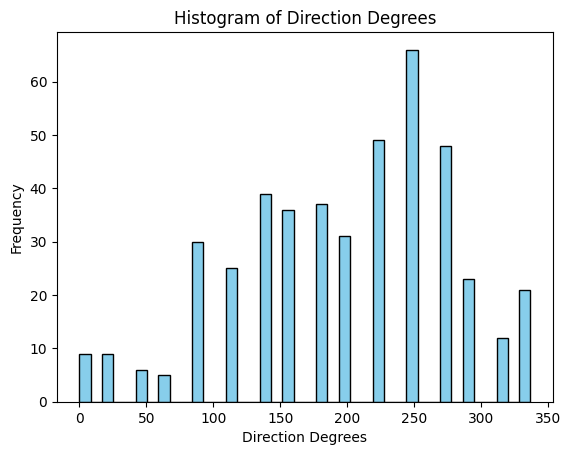

In [15]:
plt.hist(merged['Direction_Degrees'], bins=40, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Direction Degrees')
plt.ylabel('Frequency')
plt.title('Histogram of Direction Degrees')

# Show the plot
plt.show()

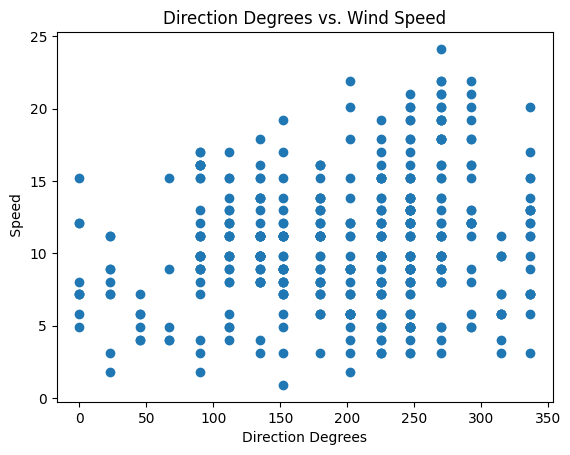

In [16]:
plt.scatter(merged['Direction_Degrees'],merged['Speed'])
plt.xlabel('Direction Degrees')
plt.ylabel(' Speed')
plt.title('Direction Degrees vs. Wind Speed')
plt.show()


In [17]:
newdf = merged.interpolate(method='bfill')
newdf.head()

,Total,Speed,Direction_Degrees
0,18.591870,8.9408,202.0
1,18.524188,8.9408,202.0
2,18.407716,8.9408,202.0
3,18.561551,8.9408,202.0
4,18.279533,8.9408,202.0


In [18]:
newdf.to_csv('full_data.csv')


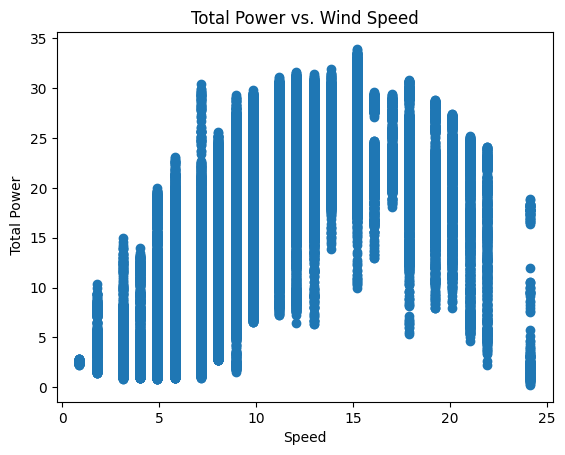

In [19]:


# Plotting mean_total against speed
plt.scatter(newdf['Speed'], newdf['Total'])
plt.xlabel('Speed')
plt.ylabel(' Total Power')
plt.title('Total Power vs. Wind Speed')
plt.show()


## EDA

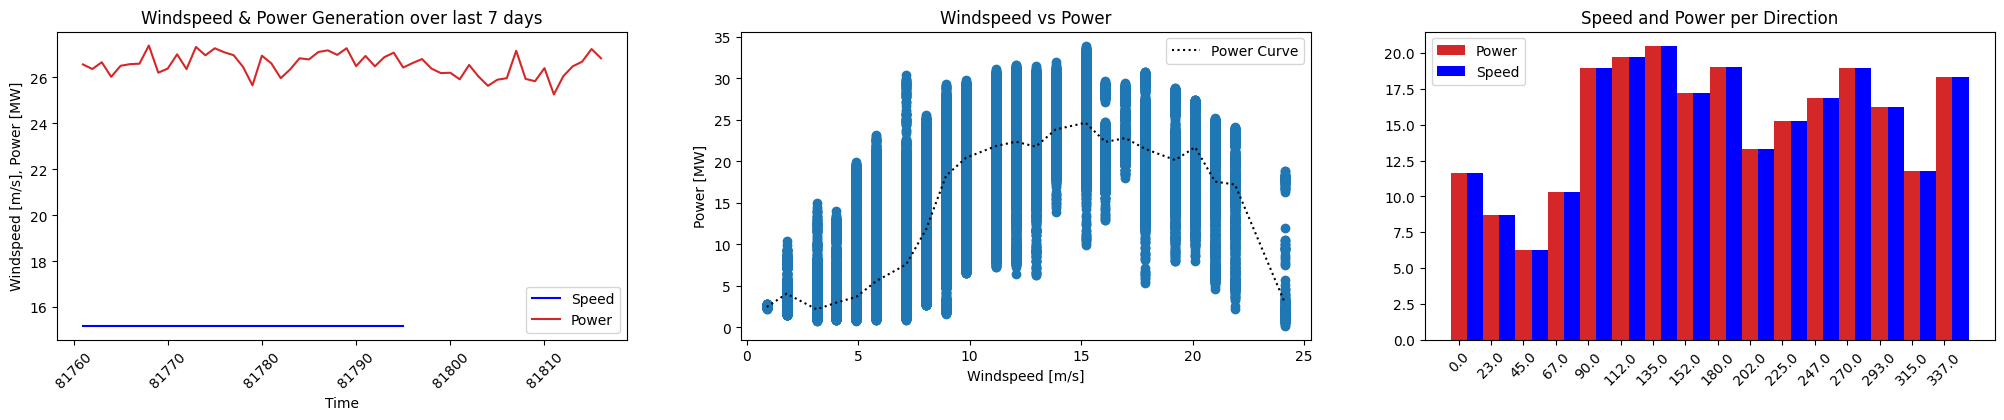

In [20]:
# Subplots
fig, ax = plt.subplots(1,3, figsize=(25,4))

# Speed and Power for the last 7 days
ax[0].plot(newdf["Speed"].tail(int(7*24/3)), label="Speed", color="blue") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].plot(newdf["Total"].tail(int(7*24/3)), label="Power", color="tab:red") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].set_title("Windspeed & Power Generation over last 7 days")
ax[0].set_xlabel("Time")
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
ax[0].legend()

# Speed vs Total (Power Curve nature)
ax[1].scatter(newdf["Speed"], newdf["Total"])
power_curve = newdf.groupby("Speed").median(numeric_only=True)["Total"]
ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
ax[1].legend()
ax[1].set_title("Windspeed vs Power")
ax[1].set_ylabel("Power [MW]")
ax[1].set_xlabel("Windspeed [m/s]")

# Speed and Power per Wind Direction
wind_grouped_by_direction = newdf.groupby("Direction_Degrees").mean(numeric_only=True).reset_index()
bar_width = 0.5
x = np.arange(len(wind_grouped_by_direction.index))

ax[2].bar(x, wind_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red")
ax[2].bar(x + bar_width, wind_grouped_by_direction.Total, width=0.5, label="Speed", color="blue")
ax[2].legend()
ax[2].set_xticks(x)
ax[2].set_xticklabels(wind_grouped_by_direction.Direction_Degrees)
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Speed and Power per Direction");

In [21]:
newdf.shape

(81817, 3)

In [22]:
newdf.dropna(how='all')
newdf.dropna(axis='columns')

,Total
0,18.591870
1,18.524188
2,18.407716
3,18.561551
4,18.279533
...,...
81812,26.054348
81813,26.484115
81814,26.686420
81815,27.236970


In [23]:
# Count NA values in each column
na_counts = newdf.isna().sum()

# Print the result
print(na_counts)

Total                 0
Speed                21
Direction_Degrees    21
dtype: int64


In [24]:
newdf.shape

(81817, 3)

In [25]:
df_cleaned = newdf.dropna()

In [26]:
df_cleaned.shape
df_cleaned.head()

,Total,Speed,Direction_Degrees
0,18.591870,8.9408,202.0
1,18.524188,8.9408,202.0
2,18.407716,8.9408,202.0
3,18.561551,8.9408,202.0
4,18.279533,8.9408,202.0


## Step 2 Pipeline and data transformations

In [27]:
# A very basic pipeline
pipeline_example = Pipeline([
    # Transformations
    ("Scaler", StandardScaler()),
    # Estimator
    ("Linear Regression", LinearRegression())
])

## Evaluate your model

In [28]:
# Select our feature variables and our target variable.


X = df_cleaned["Speed"].values.reshape(-1,1)
y = df_cleaned["Total"].values.reshape(-1,1)

# Split the data so we can test how well our model performs in unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y) # -> You might want to use another split method

# Train our model
pipeline_example.fit(X_train, y_train)

# Evaluate the model, using MAE as a metric
mae = mean_absolute_error(pipeline_example.predict(X_test), y_test)
print(mae)

5.127531978955357


In [29]:
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# Start MLflow run
with mlflow.start_run(run_name="Lin_regre_1feature_Speed") as run:

    # Define your pipeline
    pipeline_example = Pipeline([
        # Transformations
        ("Scaler", StandardScaler()),
        # Estimator
        ("Linear Regression", LinearRegression())
    ])

    # Select our feature variables and our target variable.
    X = df_cleaned["Speed"].values.reshape(-1,1)
    y = df_cleaned["Total"].values.reshape(-1,1)

    # Split the data so we can test how well our model performs in unseen data
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Train our model
    pipeline_example.fit(X_train, y_train)

    # Evaluate the model, using MAE as a metric
    mae = mean_absolute_error(pipeline_example.predict(X_test), y_test)

    # Log parameters
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_param("feature", "Speed")

    # Log metrics
    mlflow.log_metric("MAE", mae)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_example, "model")

 

c:\Users\45911\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [30]:
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


# Start MLflow run
with mlflow.start_run(run_name="Lin_regre_1feature_Direction") as run:

    # Define your pipeline
    pipeline_example = Pipeline([
        # Transformations
        ("Scaler", StandardScaler()),
        # Estimator
        ("Linear Regression", LinearRegression())
    ])

    # Select our feature variables and our target variable.
    X = df_cleaned["Direction_Degrees"].values.reshape(-1,1)
    y = df_cleaned["Total"].values.reshape(-1,1)

    # Split the data so we can test how well our model performs in unseen data
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # Train our model
    pipeline_example.fit(X_train, y_train)

    # Evaluate the model, using MAE as a metric
    mae = mean_absolute_error(pipeline_example.predict(X_test), y_test)

    # Log parameters
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_param("feature", "Speed")

    # Log metrics
    mlflow.log_metric("MAE", mae)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_example, "model")

 

In [31]:
# Select our feature variables and our target variable.
X = df_cleaned[["Speed", "Direction_Degrees"]]
y = df_cleaned["Total"]

# Split the data so we can test how well our model performs in unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Start MLflow run for Linear Regression model with 2 features
with mlflow.start_run(run_name="Lin_reg_2features") as run_lr_2_features:

    # Define your pipeline for Linear Regression with 2 features
    pipeline_lr_2_features = Pipeline([
        # Transformations
        ("Scaler", StandardScaler()),
        # Estimator
        ("Linear Regression", LinearRegression())
    ])

    # Train the Linear Regression model with 2 features
    pipeline_lr_2_features.fit(X_train, y_train)

    # Evaluate the model, using MAE as a metric
    mae_lr_2_features = mean_absolute_error(pipeline_lr_2_features.predict(X_test), y_test)

    # Log parameters for Linear Regression model with 2 features
    mlflow.log_param("model", "Linear Regression")
    mlflow.log_param("features", "Speed, Direction_Degrees")

    # Log metrics for Linear Regression model with 2 features
    mlflow.log_metric("MAE", mae_lr_2_features)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_lr_2_features, "lr_2_features_model")

    # Print MAE for Linear Regression model with 2 features
    print("MAE (LR with 2 features):", mae_lr_2_features)

    # Retrieve the MLflow run ID for Linear Regression model with 2 features
    run_id_lr_2_features = run_lr_2_features.info.run_id
    print("MLflow Run ID (LR with 2 features):", run_id_lr_2_features)


MAE (LR with 2 features): 5.074485252718382
MLflow Run ID (LR with 2 features): 72e7202e187f4983843e90e3357b327d


In [32]:
from sklearn.neighbors import KNeighborsRegressor

# Start MLflow run for KNN model with a specific run name
with mlflow.start_run(run_name="KNN_Model") as run_knn:

    # Define your pipeline for KNN
    pipeline_knn = Pipeline([
        # Transformations (if necessary)
        ("Scaler", StandardScaler()),  # Scale features for better performance of KNN
        # Estimator
        ("KNN", KNeighborsRegressor())  # Initialize KNN model
    ])

    # Train the KNN model
    pipeline_knn.fit(X_train, y_train)

    # Evaluate the model, using MAE as a metric
    mae_knn = mean_absolute_error(pipeline_knn.predict(X_test), y_test)

    # Log parameters for KNN model
    mlflow.log_param("model", "K-Nearest Neighbors")
    mlflow.log_param("feature", "Speed")

    # Log metrics for KNN model
    mlflow.log_metric("MAE", mae_knn)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_knn, "knn_model")

    # Print MAE for KNN model
    print("MAE (KNN):", mae_knn)

    # Retrieve the MLflow run ID for KNN model
    run_id_knn = run_knn.info.run_id
    print("MLflow Run ID (KNN):", run_id_knn)


MAE (KNN): 2.785354747117218
MLflow Run ID (KNN): 0ae9aaf67c09471fab02b5fff05aca1e


In [33]:
# Select our feature variables and our target variable.
X = df_cleaned[["Speed", "Direction_Degrees"]]
y = df_cleaned["Total"]

from sklearn.ensemble import RandomForestRegressor

# Start MLflow run for Random Forest model with a specific run name
with mlflow.start_run(run_name="RandomForest_Model") as run_rf:

    # Define your pipeline for Random Forest
    pipeline_rf = Pipeline([
        # Transformations (if necessary)
        ("Scaler", StandardScaler()),  # Scale features for better performance
        # Estimator
        ("RandomForest", RandomForestRegressor())  # Initialize Random Forest model
    ])

    # Train the Random Forest model
    pipeline_rf.fit(X_train, y_train)

    # Evaluate the model, using MAE as a metric
    mae_rf = mean_absolute_error(pipeline_rf.predict(X_test), y_test)

    # Log parameters for Random Forest model
    mlflow.log_param("model", "Random Forest")
    mlflow.log_param("feature", "Speed")

    # Log metrics for Random Forest model
    mlflow.log_metric("MAE", mae_rf)

    # Log the trained model as an artifact
    mlflow.sklearn.log_model(pipeline_rf, "random_forest_model")

    # Print MAE for Random Forest model
    print("MAE (Random Forest):", mae_rf)

    # Retrieve the MLflow run ID for Random Forest model
    run_id_rf = run_rf.info.run_id
    print("MLflow Run ID (Random Forest):", run_id_rf)


MAE (Random Forest): 2.5679316149236087
MLflow Run ID (Random Forest): cd30051666fa4e96b4ae2c876fb7b858
